In [10]:
##### Step 1: Import necessary modules
##### =================================
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [11]:
##### Step 2: Get market data
##### =========================
tickers = [
    '^GSPC',    # S&P 500
    '^IXIC',    # NASDAQ
    'SPY',      # SPY (S&P 500 ETF)
    'QQQ',      # QQQ (NASDAQ ETF)
    'XLK',      # Tech Sector ETF
    'XLF',      # Financials ETF
    'XLE',      # Energy ETF
    '^VIX',     # Market Volatility (VIX)"
]

Symbol = ['S&P500', 'NASDAQ', 'SPY', 'QQQ', 'XLK', 'XLF', 'XLE', 'VIX']

# Define date range
start_date = '2021-01-01'
end_date = '2021-12-31'

# Fetch data
financial_data = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    # Optional: Adjust granularity (default is daily)
    interval='1d',  # '1d', '1wk', '1mo'
    # Fetch adjusted close prices to account for splits/dividends
    auto_adjust=False
)

# Extract "Adj Close" for all tickers
Adj_close = financial_data['Adj Close'].dropna()
Adj_close.columns = Symbol
print('\nDataFrame with Adjusted Close Prices: \n',Adj_close.head())

# Calculate daily percentage returns
Daily_returns = Adj_close.pct_change()  # Returns in percentage
Daily_returns = Daily_returns.dropna()  # Remove first row (NaN)
print('\nDataFrame with Daily Returns: \n', Daily_returns.head())

# Calculate cumulative returns (assuming reinvestment)
Cumulative_returns = (1 + Daily_returns ).cumprod() - 1
print('\nDataFrame with Cumulative Returns: \n', Cumulative_returns.head())

# Generate csv file
Daily_returns.to_csv('./output/Mkt_P2_Daily_returns.csv')
Adj_close.to_csv('./output/Mkt_P2_Adjusted_close_prices.csv')


[*********************100%***********************]  8 of 8 completed


DataFrame with Adjusted Close Prices: 
                 S&P500      NASDAQ        SPY        QQQ         XLK  \
Date                                                                   
2021-01-04  301.685425  348.299408  32.473282  27.043438  123.768997   
2021-01-05  304.172638  350.698273  33.927574  27.164328  124.572182   
2021-01-06  299.959076  352.794952  34.962669  28.363989  122.423897   
2021-01-07  307.215729  358.036591  35.475960  28.773176  125.723763   
2021-01-08  311.165833  360.076569  35.433178  28.754578  126.536621   

                    XLF           XLE        VIX  
Date                                              
2021-01-04  3700.649902  12698.450195  26.969999  
2021-01-05  3726.860107  12818.959961  25.340000  
2021-01-06  3748.139893  12740.790039  25.070000  
2021-01-07  3803.790039  13067.480469  22.370001  
2021-01-08  3824.679932  13201.980469  21.559999  

DataFrame with Daily Returns: 
               S&P500    NASDAQ       SPY       QQQ       XLK    

In [12]:
#================================================================================================
# Load sentiment data
senti_path='./data/finbert_sentiment_analysis_results_update.csv'
sentiment_df = pd.read_csv(senti_path)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

pivoted = sentiment_df.pivot(index='date', columns='cluster', values='sentiment_score')
pivoted.columns = ['cluster_0', 'cluster_1']
pivoted.reset_index(inplace=True)
pivoted['lagged_cluster_0'] = pivoted['cluster_0'].shift(1)
pivoted['lagged_cluster_1'] = pivoted['cluster_1'].shift(1)

# Load financial data
Adjusted_close = pd.read_csv('./output/Mkt_P2_Adjusted_close_prices.csv')
Adjusted_close['Date'] = pd.to_datetime(Adjusted_close['Date'])

#================================================================================================

In [13]:
##### Step 3: Merge news sentiment with market data
##### ===============================================

## Merge sentiment and financial data
merged_df = pd.merge(pivoted, Adjusted_close, left_on='date', right_on="Date", how="inner").drop("Date", axis=1)
merged_df[['SP500_ret', 'NASDAQ_ret', 'SPY_ret', 'QQQ_ret', 'XLK_ret', 'XLF_ret', 'XLE_ret', 'VIX_ret']] = merged_df[['S&P500', 'NASDAQ', 'SPY', 'QQQ', 'XLK', 'XLF', 'XLE', 'VIX']].pct_change()
merged_df = merged_df.dropna()
display(merged_df)
merged_df.to_csv('./output/Mkt_P2_Align_sentiment_clusters_with_market_data.csv')


,date,cluster_0,cluster_1,lagged_cluster_0,lagged_cluster_1,S&P500,NASDAQ,SPY,QQQ,XLK,...,XLE,VIX,SP500_ret,NASDAQ_ret,SPY_ret,QQQ_ret,XLK_ret,XLF_ret,XLE_ret,VIX_ret
1,2021-01-05,0.037397,0.317329,-0.065544,0.489641,304.172638,350.698273,33.927574,27.164328,124.572182,...,12818.959961,25.340000,0.008244,0.006887,0.044784,0.004470,0.006489,0.007083,0.009490,-0.060437
2,2021-01-06,0.122368,0.240956,0.037397,0.317329,299.959076,352.794952,34.962669,28.363989,122.423897,...,12740.790039,25.070000,-0.013853,0.005979,0.030509,0.044163,-0.017245,0.005710,-0.006098,-0.010655
3,2021-01-07,0.060187,0.348932,0.122368,0.240956,307.215729,358.036591,35.475960,28.773176,125.723763,...,13067.480469,22.370001,0.024192,0.014857,0.014681,0.014426,0.026954,0.014847,0.025641,-0.107698
4,2021-01-08,0.083080,0.338398,0.060187,0.348932,311.165833,360.076569,35.433178,28.754578,126.536621,...,13201.980469,21.559999,0.012858,0.005698,-0.001206,-0.000646,0.006465,0.005492,0.010293,-0.036209
5,2021-01-11,0.110318,0.458806,0.097934,0.382603,306.669495,357.649384,35.989227,28.847572,125.491493,...,13036.429688,24.080000,-0.014450,-0.006741,0.015693,0.003234,-0.008259,-0.006555,-0.012540,0.116883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,2021-12-23,-0.008471,0.298721,0.012677,0.245043,389.000916,450.377167,49.159073,36.737747,168.628906,...,15653.370117,17.959999,0.007539,0.006222,0.000547,0.005179,0.005582,0.006224,0.008471,-0.035964
235,2021-12-27,0.054619,0.229145,0.026174,0.305784,395.430054,456.750977,50.233597,37.116283,172.246445,...,15871.259766,17.680000,0.016527,0.014152,0.021858,0.010304,0.021453,0.013839,0.013920,-0.015590
236,2021-12-28,0.042442,0.274292,0.054619,0.229145,393.597321,456.377686,50.197777,37.135212,171.349350,...,15781.719727,17.540001,-0.004635,-0.000817,-0.000713,0.000510,-0.005208,-0.001010,-0.005642,-0.007919
237,2021-12-29,0.093093,0.298501,0.042442,0.274292,393.538513,456.961548,49.875427,37.087894,171.495621,...,15766.219727,16.950001,-0.000149,0.001279,-0.006422,-0.001274,0.000854,0.001402,-0.000982,-0.033637


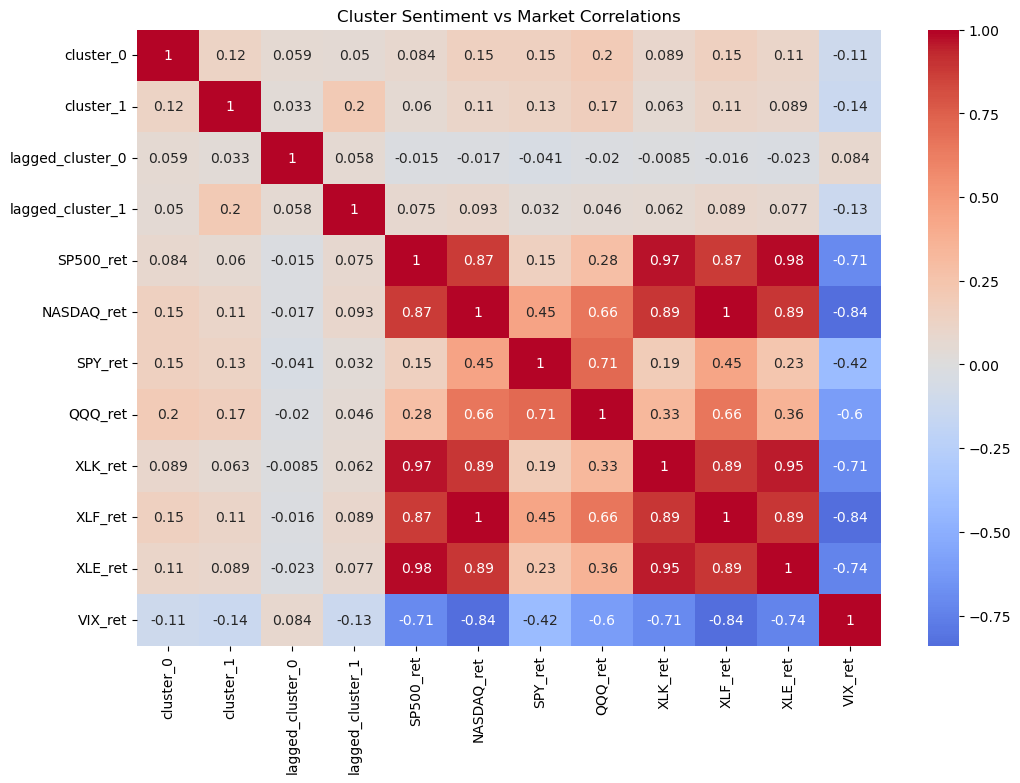

In [14]:
## Calculate correlations
correlation_matrix = merged_df[['cluster_0', 'cluster_1','lagged_cluster_0', 'lagged_cluster_1','SP500_ret', 'NASDAQ_ret', 'SPY_ret', 'QQQ_ret', 'XLK_ret', 'XLF_ret', 'XLE_ret', 'VIX_ret']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Sentiment vs Market Correlations')
plt.show()


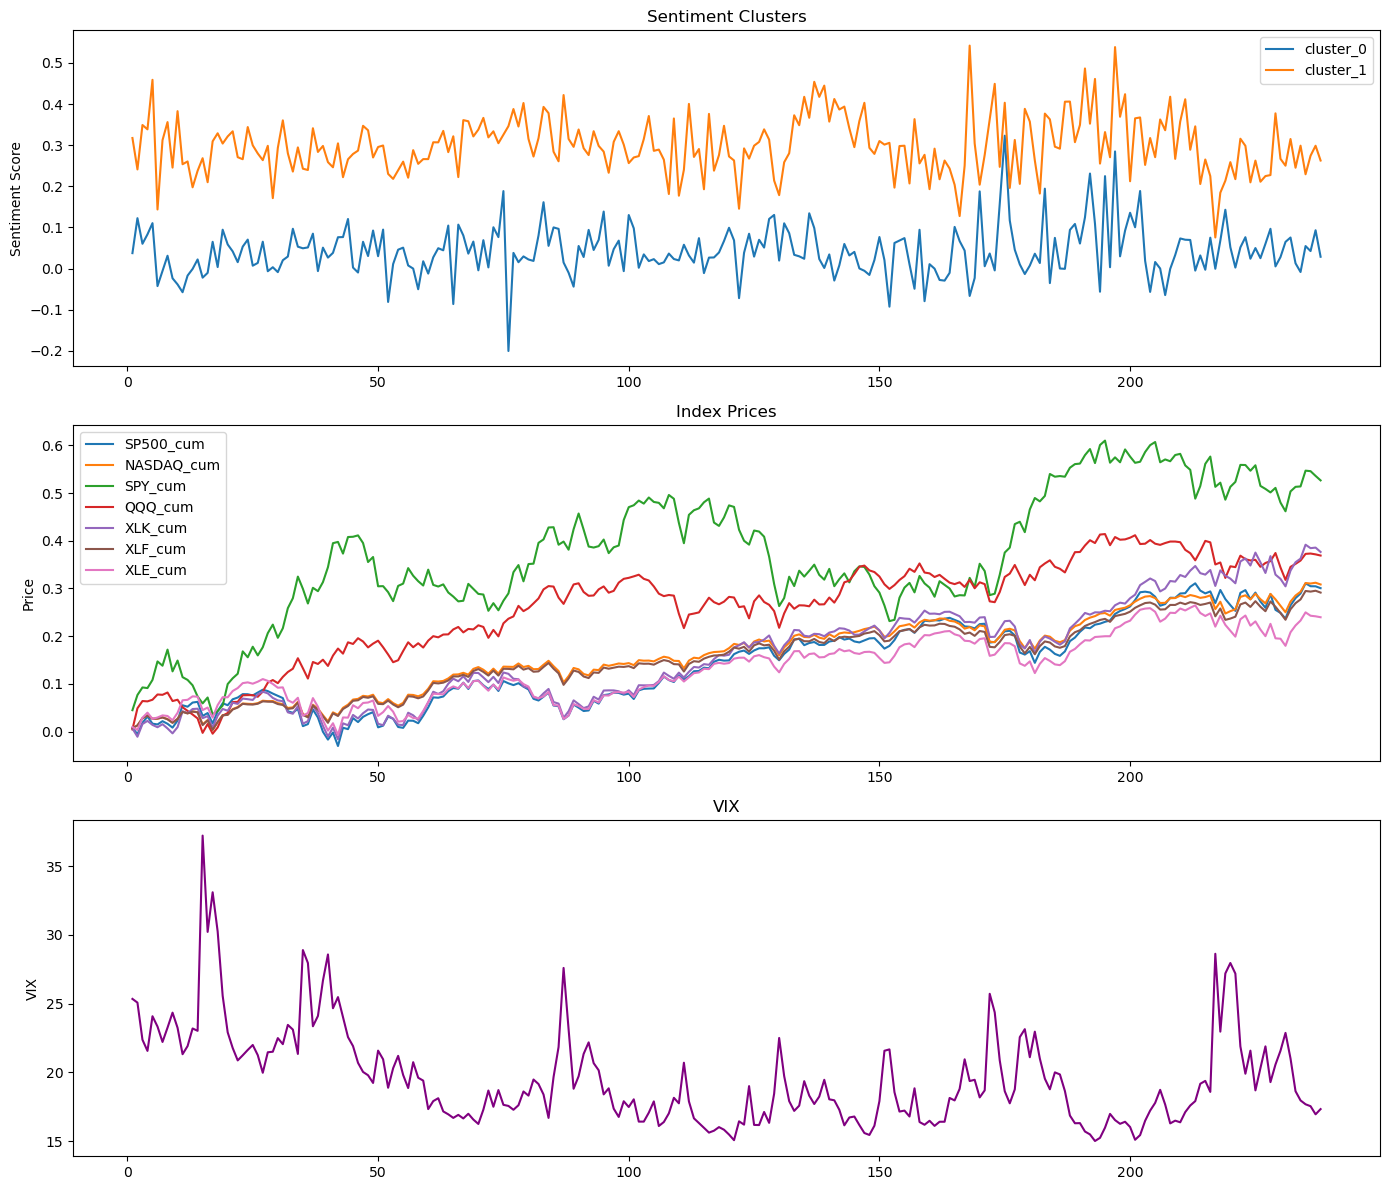

In [15]:
#3 Visualization

fig, ax = plt.subplots(3, 1, figsize=(14, 12))

# Cluster Sentiment
merged_df[['cluster_0', 'cluster_1']].plot(ax=ax[0], title='Sentiment Clusters')
ax[0].set_ylabel('Sentiment Score')

# Index Prices
merged_df[['SP500_cum', 'NASDAQ_cum', 'SPY_cum', 'QQQ_cum', 'XLK_cum', 'XLF_cum', 'XLE_cum']] = (1 + merged_df[['SP500_ret', 'NASDAQ_ret', 'SPY_ret', 'QQQ_ret', 'XLK_ret', 'XLF_ret', 'XLE_ret']]).cumprod() - 1
merged_df = merged_df.dropna()
merged_df[['SP500_cum', 'NASDAQ_cum', 'SPY_cum', 'QQQ_cum', 'XLK_cum', 'XLF_cum', 'XLE_cum']].plot(ax=ax[1], title='Index Prices')
ax[1].set_ylabel('Price')

# VIX
merged_df['VIX'].plot(ax=ax[2], title='VIX', color='purple')
ax[2].set_ylabel('VIX')

plt.tight_layout()
plt.show()

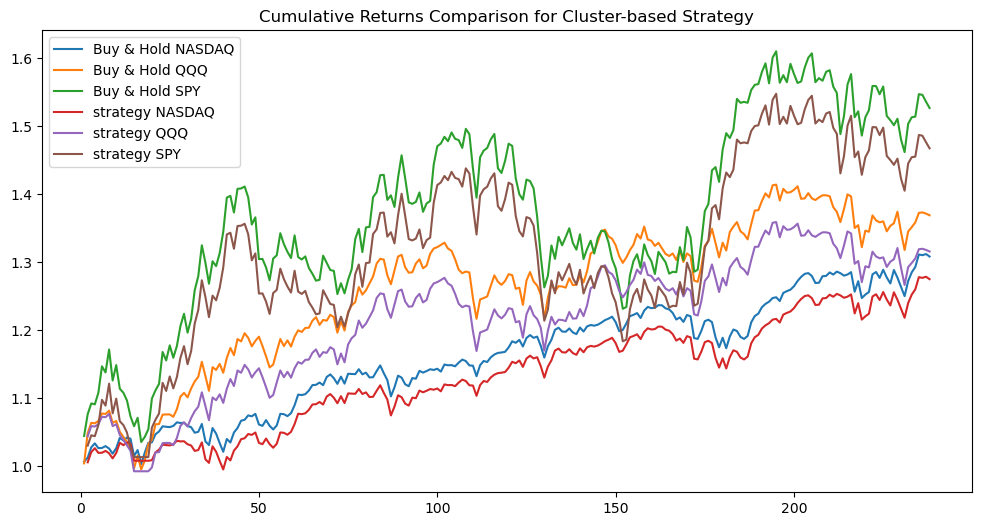


Cluster-Based Strategy Performance Metrics:
              NASDAQ_ret   QQQ_ret   SPY_ret  Cluster strategy_returns1  \
Total Return    0.308352  0.368970  0.526516                   0.275087   
Sharpe Ratio    2.214795  1.837525  1.620228                   2.069111   
Max Drawdown   -0.051142 -0.084221 -0.176758                  -0.051142   
Volatility      0.008348  0.012029  0.019230                   0.008123   
Win Rate        0.584034  0.558824  0.546218                   0.567227   

              Cluster strategy_returns2  Cluster strategy_returns3  
Total Return                   0.315694                   0.467287  
Sharpe Ratio                   1.651155                   1.508547  
Max Drawdown                  -0.084221                  -0.176758  
Volatility                     0.011803                   0.018909  
Win Rate                       0.542017                   0.529412  


In [16]:
##### Step 4: Trading Strategy
##### ===============================================

# Key Findings
# Both clusters show stronger positive relationship with NASDAQ, QQQ, SPY
# Both clusters show inverse relationship with VIX: Cluster 0: -0.11; Cluster 1: -0.14, indicating higher sentiment reduces market fear.


### ----- Strategy 1: Cluster-Based Strategy -----

# Generate signals
merged_df['signalC'] = np.where(
    (merged_df['cluster_1'] > 0.2) & (merged_df['VIX'] < 20), 
    1,  # Long
    np.where(
        (merged_df['cluster_0'] < 0.1) & (merged_df['VIX'] > 30),
        0,  # Cash
        1  # Stay invested
    )
)


# ==================================================================================================

# Calculate returns
merged_df['Cluster strategy_returns1'] = merged_df['signalC'].shift(1) * merged_df['NASDAQ_ret']
merged_df['Cluster strategy_returns2'] = merged_df['signalC'].shift(1) * merged_df['QQQ_ret']
merged_df['Cluster strategy_returns3'] = merged_df['signalC'].shift(1) * merged_df['SPY_ret']


# Backtest results
cumulative_returns = (1 + merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Cluster strategy_returns1','Cluster strategy_returns2','Cluster strategy_returns3']]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns Comparison for Cluster-based Strategy')
plt.legend(['Buy & Hold NASDAQ', 'Buy & Hold QQQ','Buy & Hold SPY', 'strategy NASDAQ', 'strategy QQQ','strategy SPY'])
plt.show()

# Performance metrics
def calculate_metrics(returns):
    cum_r = (1 + returns).cumprod()
    total_return = cum_r.iloc[-1] - 1
    sharpe_ratio = np.sqrt(252) * returns.mean() /returns.std()
    max_drawdown = ((cum_r - cum_r.cummax())/cum_r.cummax()).min()
    return pd.Series({
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Volatility': returns.std(),
        'Win Rate': (returns > 0).mean()
    })

ClusterBased_performance = merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Cluster strategy_returns1','Cluster strategy_returns2','Cluster strategy_returns3']].apply(calculate_metrics)
print("\nCluster-Based Strategy Performance Metrics:")
print(ClusterBased_performance)

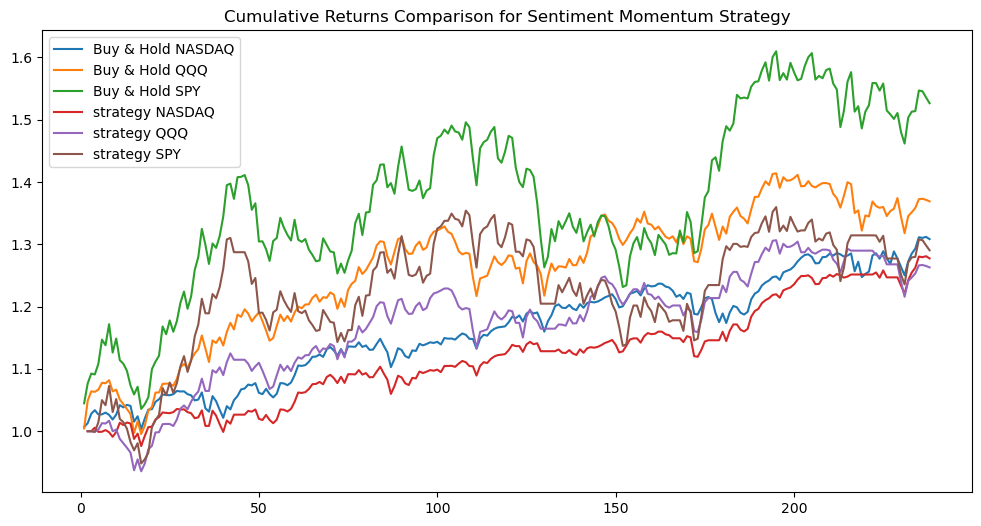


Sentiment Momentum Strategy Performance Metrics:
              NASDAQ_ret   QQQ_ret   SPY_ret  Momentum strategy_returns1  \
Total Return    0.308352  0.368970  0.526516                    0.277410   
Sharpe Ratio    2.214795  1.837525  1.620228                    2.269159   
Max Drawdown   -0.051142 -0.084221 -0.176758                   -0.039586   
Volatility      0.008348  0.012029  0.019230                    0.007423   
Win Rate        0.584034  0.558824  0.546218                    0.508403   

              Momentum strategy_returns2  Momentum strategy_returns3  
Total Return                    0.262965                    0.290489  
Sharpe Ratio                    1.574301                    1.105868  
Max Drawdown                   -0.079784                   -0.160396  
Volatility                      0.010490                    0.017688  
Win Rate                        0.474790                    0.462185  


In [17]:
### ----- Strategy 2: Sentiment Momentum Strategy -----

merged_df['cluster_spread']=  merged_df['cluster_1'] - merged_df['cluster_0']
merged_df['sentiment_ma'] = merged_df['cluster_spread'].rolling(3).mean()
merged_df['signalM'] = 0
merged_df.loc[merged_df['sentiment_ma'] > 0.2, 'signalM'] = 1  # Buy
merged_df.loc[merged_df['sentiment_ma'] < -0.1, 'signalM'] = -1  # Sell

# ==================================================================================================

# Calculate returns
merged_df['Momentum strategy_returns1'] = merged_df['signalM'].shift(1) * merged_df['NASDAQ_ret']
merged_df['Momentum strategy_returns2'] = merged_df['signalM'].shift(1) * merged_df['QQQ_ret']
merged_df['Momentum strategy_returns3'] = merged_df['signalM'].shift(1) * merged_df['SPY_ret']


# Backtest results
cumulative_returns = (1 + merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Momentum strategy_returns1','Momentum strategy_returns2','Momentum strategy_returns3']]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns Comparison for Sentiment Momentum Strategy')
plt.legend(['Buy & Hold NASDAQ', 'Buy & Hold QQQ','Buy & Hold SPY', 'strategy NASDAQ', 'strategy QQQ','strategy SPY'])
plt.show()


SentimentMomentum_performance = merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Momentum strategy_returns1','Momentum strategy_returns2','Momentum strategy_returns3']].apply(calculate_metrics)
print("\nSentiment Momentum Strategy Performance Metrics:")
print(SentimentMomentum_performance)



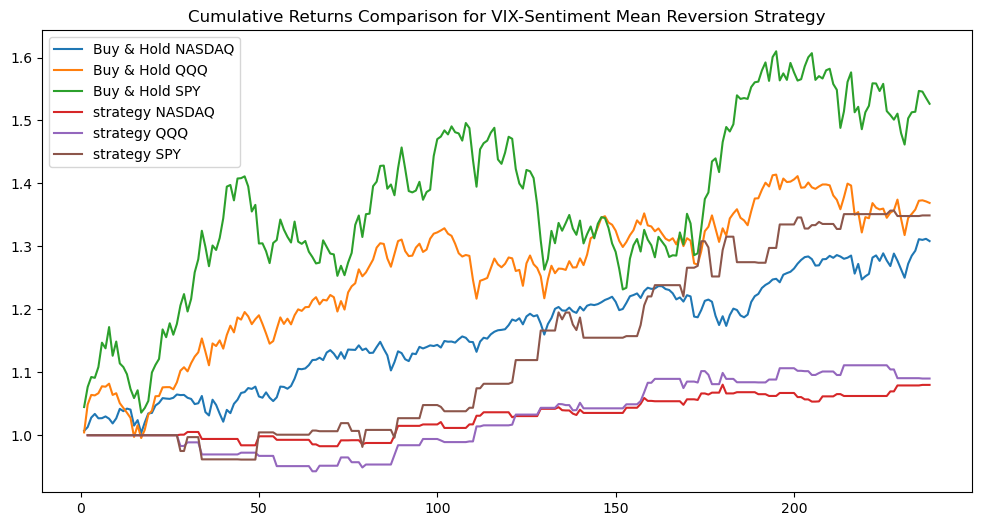


VixSentiment Strategy Performance Metrics:
              NASDAQ_ret   QQQ_ret   SPY_ret  Vix strategy_returns1  \
Total Return    0.308352  0.368970  0.526516               0.079923   
Sharpe Ratio    2.214795  1.837525  1.620228               1.541510   
Max Drawdown   -0.051142 -0.084221 -0.176758              -0.024909   
Volatility      0.008348  0.012029  0.019230               0.003401   
Win Rate        0.584034  0.558824  0.546218               0.134454   

              Vix strategy_returns2  Vix strategy_returns3  
Total Return               0.090034               0.349143  
Sharpe Ratio               1.210178               2.127343  
Max Drawdown              -0.057296              -0.042814  
Volatility                 0.004931               0.009788  
Win Rate                   0.126050               0.142857  


In [18]:
### ----- Strategy 3: VIX-Sentiment Mean Reversion -----

merged_df['vix_ma20'] = merged_df['VIX'].rolling(20).mean()
merged_df['composite_signal'] = np.where(
    (merged_df['cluster_spread'] > 0.3) & (merged_df['VIX'] > merged_df['vix_ma20']), 
    1, 
    np.where(
        (merged_df['cluster_spread'] < 0.2) & (merged_df['VIX'] < merged_df['vix_ma20']),
        -1, 
        0
    )
)

# ==================================================================================================

# Calculate returns
merged_df['Vix strategy_returns1'] = merged_df['composite_signal'].shift(1) * merged_df['NASDAQ_ret']
merged_df['Vix strategy_returns2'] = merged_df['composite_signal'].shift(1) * merged_df['QQQ_ret']
merged_df['Vix strategy_returns3'] = merged_df['composite_signal'].shift(1) * merged_df['SPY_ret']


# Backtest results
cumulative_returns = (1 + merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Vix strategy_returns1','Vix strategy_returns2','Vix strategy_returns3']]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns Comparison for VIX-Sentiment Mean Reversion Strategy')
plt.legend(['Buy & Hold NASDAQ', 'Buy & Hold QQQ','Buy & Hold SPY', 'strategy NASDAQ', 'strategy QQQ','strategy SPY'])
plt.show()


VIXSentiment_performance = merged_df[['NASDAQ_ret','QQQ_ret','SPY_ret', 'Vix strategy_returns1','Vix strategy_returns2','Vix strategy_returns3']].apply(calculate_metrics)
print("\nVixSentiment Strategy Performance Metrics:")
print(VIXSentiment_performance)
